In [ ]:
!pip install catboost
!pip install transformers

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve
import os
from catboost import  Pool
import pandas as pd
from torch.utils.data import DataLoader, Dataset

from catboost import CatBoostClassifier
from transformers import AutoModel, AutoTokenizer
import torch

In [ ]:
df = pd.read_csv('train_spam.csv').head()
df

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


(array([11469.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4809.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

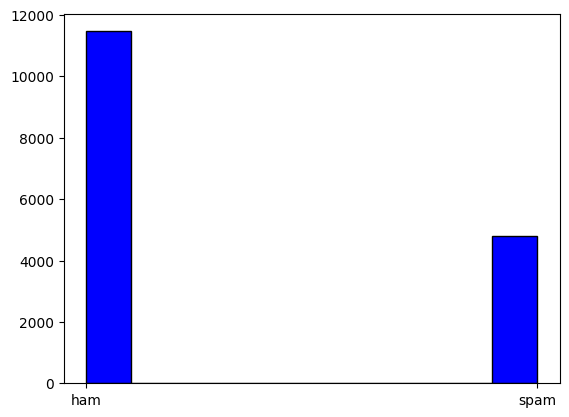

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('train_spam.csv')

# matplotlib histogram
plt.hist(df['text_type'], color = 'blue', edgecolor = 'black')




построим датасет чтобы подавать на вход трансформеру батчи

In [ ]:
class CorpusDataset(Dataset):
    def __init__(self, df, encoder):
        self.df = df
        self.texts = self.df['text'].values
        self.encoder = encoder
        self.labels = self.encoder.transform(self.df['text_type'].values)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return self.labels[idx], self.texts[idx]

Будем использовать для хороших эмбеддингов e5


In [ ]:
class EmbedModel:

    def __init__(self, model, tokenizer, loader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.loader = loader
        self.tokenizer = tokenizer
        self.model.eval()



    def _batch_embeddings(self, batch_texts):
        tokens = self.tokenizer(
            batch_texts, padding=True, max_length=512, truncation=True, return_tensors="pt"
        ).to(self.device)
        out = self.model(**tokens)
        last_hidden = out.last_hidden_state.masked_fill(
            ~tokens["attention_mask"][..., None].bool(), 0.0
        )
        embeds = last_hidden.sum(dim=1) / \
                         tokens["attention_mask"].sum(dim=1)[..., None]
        return embeds.cpu().numpy().tolist()

    def get_embeddings_labels(self):
        all_embs = []
        all_labels = []
        for labels, texts in self.loader:
            with torch.no_grad():
                embs = self._batch_embeddings(texts)
                # all_embs = np.concatenate((all_embs,embs), axis=0)
                # all_labels = np.concatenate((all_labels, labels), axis=0)
                all_embs.extend(embs)
                all_labels.extend(labels)
        return np.array(all_labels), np.array(all_embs)

поверх e5 обучим реализацию градиентоного бустинга - модель CatBoost

In [ ]:
def fit_catboost(train_data, test_data ):
    CatBoostClassifier(eval_metric='AUC', verbose=100)
    model = CatBoostClassifier(eval_metric='AUC', iterations=100, learning_rate=0.1, depth=6)
    model.fit(train_data, eval_set = test_data, verbose=False, plot = True)
    return model

Попробуем обучить катбуст из коробки с текстовыми фичами

In [ ]:
def fit_box_catboost(train_data, test_data):
    train_data = Pool(train_data['text'], train_data['text_type'],
    text_features= ['text'], feature_names=['text'])
    model = CatBoostClassifier(eval_metric='AUC', iterations=100, learning_rate=0.1, depth=6)
    model.fit(train_data, eval_set=(test_data['text'].values,test_data['text_type'].values ), verbose=False,
              plot=True)
    return model

Обучим линейную модель для классификации эмбеддингами e5

In [ ]:
def fit_log_reg(X, y):
    logreg = LogisticRegression()
    logreg.fit(X, y)
    return logreg

In [ ]:
def tests():
    df = pd.read_csv('train_spam.csv')
    train, test = train_test_split(df, test_size=0.35, random_state=0)
    cb_box = fit_box_catboost(train, test)
    predictions_cb_box = cb_box.predict_proba(list(map(lambda x: [x], test['text'].values)))
    encoder = LabelEncoder().fit(test['text_type'].values)
    train_dataset = CorpusDataset(train, encoder)
    test_dataset = CorpusDataset(test, encoder)
    loader_train = DataLoader(train_dataset, batch_size=100, shuffle=True)
    loader_test = DataLoader(test_dataset, batch_size=100, shuffle=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_id = "intfloat/e5-base-v2"


    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModel.from_pretrained(model_id).to(device)
    labels_train, embed_train = EmbedModel(model, tokenizer, loader_train).get_embeddings_labels()
    labels_test, embed_test = EmbedModel(model, tokenizer, loader_test).get_embeddings_labels()
    train_data, test_data = Pool(embed_train, labels_train), Pool(embed_test, labels_test)
    cb = fit_catboost(train_data, test_data)
    predictions_e5 = cb.predict_proba(embed_test)
    logreg = fit_log_reg(embed_train, labels_train)
    logreg_predictions = logreg.predict_proba(embed_test)

    ret ={'metric' : ['ROC AUC'],
     'e5 + catboost' : [roc_auc_score(labels_test, predictions_e5[:, 1])],
     'cb_box': [roc_auc_score(test['text_type'].values, predictions_cb_box[:, 1])],
     'e5 + logreg': [roc_auc_score(labels_test, logreg_predictions[:, 1])]}
    pd.DataFrame(ret).to_csv('scoring_models.csv')
    ret

In [ ]:
tests()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [124]:
try:
  pd.read_csv('scoring_models.csv').drop(['Unnamed: 0'], axis=1).to_csv('scoring_models.csv', index=False)
except:
  'all is ok'
finally:
  print(pd.read_csv('scoring_models.csv'))

    metric  e5 + catboost    cb_box  e5 + logreg
0  ROC AUC       0.980354  0.979778     0.986204


Лучшая модель - логистическая регрессия над e5